# Sentiment Classification using Tweets on Apple and Google Products

Ryan McArthur, Flatiron School DS 081720
Module 4 Final Project

## Introduction

In this investigation, we are tasked with building a model that is able to effectively sort tweets based upon the sentiment of the text. We are provided with a dataset containing content, product in mention, and emotion contained within the tweet. Our target for this investigation will the emotion contained within the text. 

In [2]:
# we import all necessary tools

!pip install -U fsds

from fsds.imports import * 

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string
import re

import pandas as pd
import numpy as np

fsds v0.2.27 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

### Data

We first need to understand our data, complete some basic cleaning, and check for any issues that would prevent future modelling. 

In [4]:
# we import and inspect our dataframe

df = pd.read_csv("data/NLP_dataset.csv", encoding = 'unicode_escape')



#df.describe()
len(df)

9093

In [5]:
# we rename columns for ease of use

rename_dict = {"tweet_text" : 'text',
              'emotion_in_tweet_is_directed_at' : 'product',
              'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment'}

df = df.rename(columns = rename_dict)


df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
# we check for missing values in our columns

df['product'].value_counts(dropna = False)

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

We have missing values in our product column. Of 9093 texts, 5802 did not have a product in mention, according to the data provided to us. To see if we should complete any furuther work on this, let's check how it relates to our sentiment column. If there is a sufficient mix of classes in the non-product tweets, we'll try to classify further. If there is strong class imbalance, trying to attribute products to more tweets would not inform our model in the long run. 

In [7]:
# we investigate the sentiment of tweets with no product in mention

no_product_df = df.where(df['product'].isna() == True)

no_product_df['sentiment'].value_counts()



No emotion toward brand or product    5298
Positive emotion                       306
I can't tell                           147
Negative emotion                        51
Name: sentiment, dtype: int64

Of the 5802 texts that had no product in mention, 5445 were neutral, or 94% of entries. Attempting to process our data further to fill in some missing values in our product column would not serve our model best, as these entries are overwhelmingly neutral. 

In [8]:
# we return to checking and cleaning sentiment column

df['sentiment'].value_counts(dropna = False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [9]:
# we clean 'sentiment' column

def sentiment_cleaner(df, column):
    sentiment_list = []
    for i in df[column]:
        if i == "No emotion toward brand or product":
            sentiment_list.append('neutral')
        elif i == "I can't tell":
            sentiment_list.append('neutral')
        elif i == "Positive emotion":
            sentiment_list.append('positive')
        elif i == "Negative emotion":
            sentiment_list.append('negative') 
    df['sentiment'] = sentiment_list
    return df

df = sentiment_cleaner(df, 'sentiment')
a = df['sentiment'].value_counts()

In [13]:
a.values

array([5545, 2978,  570], dtype=int64)

Text(0.5, 1.0, 'Tweet Class Breakdown')

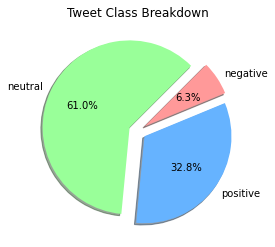

In [14]:
# we make a quick pie chart to visualize our class breakdown

vals = a.values
labels = a.index
ex = (0.1, 0.1, 0.1)
clr = ['#99ff99','#66b3ff','#ff9999']

fig, ax = plt.subplots()

ax.pie(vals, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 45, explode = ex, colors = clr)
plt.title('Tweet Class Breakdown')




In [12]:
# we inspect our df after completing our introductory cleaning 

df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive


# Natural Language Preprocessing

In order to generate a well-performing model, we must process our text data to a modellable state. We will accomplish this by:

- Removing stopwords
- Stemming text data

Important to note is that, for Tweets, links must be removed along with hashtags and other types of characters that are unique to this type of media. Because of the uniqueness of tweets, we have to construct some 'stopwords' on our own, with the help of regular expressions. 


In [13]:
# we incorporate a regex function to clean our 'text' column

def regex_cleaner(text):
    
    # we remove hashtags
    text = re.sub(r'#', '', text)

    # we remove hyperlinks
    
    # sourced through google lookup
    
    alt_url_regex =  r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)'
    url_regex = r'(?:<\w+.*?>|[^=!:\'\"/]|^)((?:https?://|www\.)[-\w]+(?:\.[-\w]+)*(?::\d+)?(?:/(?:(?:[~\w\+%-]|(?:[,.;@:][^\s$]))+)?)*(?:\?[\w\+%&=.;:-]+)?(?:\#[\w\-\.]*)?)(?:\p{P}|\s|<|$)'
    
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', text, flags=re.MULTILINE)
    text = re.sub(alt_url_regex, '', text, flags=re.MULTILINE) 
    
    return text

clean_text = []
for i in df['text']:
    cleaned = regex_cleaner(str(i))
    clean_text.append(cleaned)
    
df['text'] = clean_text

In [14]:
# we generate a list of all tweets, convert to a bag of words and tokenize

full_list = df['text'].to_list()

raw_bag = ','.join(map(str, full_list))

raw_tokens = word_tokenize(raw_bag)



In [15]:
# we inspect the frequency distribution of our raw tokens

frequency = FreqDist(raw_tokens)
frequency.most_common(100)

[(',', 12552),
 ('@', 7194),
 ('mention', 7119),
 ('.', 4891),
 ('SXSW', 4731),
 ('sxsw', 4470),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3928),
 ('to', 3519),
 ('RT', 2947),
 ('at', 2859),
 (';', 2800),
 ('&', 2707),
 ('for', 2440),
 ('!', 2398),
 ('a', 2174),
 ('Google', 2134),
 ('iPad', 2116),
 (':', 2055),
 ('Apple', 1880),
 ('in', 1830),
 ('quot', 1696),
 ('of', 1691),
 ('?', 1655),
 ('is', 1649),
 ('and', 1526),
 ('I', 1461),
 ('iPhone', 1300),
 ('on', 1271),
 ("'s", 1232),
 ('2', 1100),
 ('store', 1049),
 ('-', 972),
 ('you', 944),
 ('Austin', 900),
 ('an', 853),
 ('amp', 836),
 ('with', 805),
 (')', 801),
 ('up', 778),
 ('(', 770),
 ('it', 767),
 ('my', 711),
 ('app', 630),
 ('...', 591),
 ('Circles', 589),
 ('new', 566),
 ('be', 544),
 ('New', 519),
 ('from', 505),
 ('this', 496),
 ('by', 485),
 ('The', 483),
 ("n't", 479),
 ('out', 478),
 ('that', 468),
 ('are', 456),
 ('google', 448),
 ('Android', 443),
 ('your', 431),
 ('not', 427),
 ('Store', 423),
 ('apple', 

In [16]:
# we generate a list of stopwords and define a function to remove stopwords from a bag of words

stops = (stopwords.words('english') +
        list(string.punctuation) +
        ['“','”','...',"''",'’','``'] + 
        ["rt", "'s", "n't", "'re", "'m", "'ll", "--", "..",'link', 'mention', 'austin'] +
        [str(i) for i in range(0, 10)])

         
def rem_stops(bag, stopwords = stops):
         stops_removed = [word.lower() for word in bag if word.lower() not in stopwords]
         return stops_removed


In [17]:
# we define a function to stem our data

from nltk.stem.porter import *


def stemmer(bag):
    stemmer = PorterStemmer()
    stem_bag = []
    for word in bag:
        stem_bag.append(stemmer.stem(word))
    return stem_bag


In [18]:
# we stem and remove stopwords from our data

clean_tokens = stemmer(raw_tokens)
clean_tokens = rem_stops(clean_tokens)

frequency = FreqDist(clean_tokens)
frequency.most_common(200)

[('sxsw', 9402),
 ('googl', 2597),
 ('ipad', 2520),
 ('appl', 2303),
 ('quot', 1702),
 ('iphon', 1522),
 ('store', 1511),
 ('new', 1127),
 ('app', 1034),
 ('launch', 838),
 ('amp', 836),
 ('circl', 673),
 ('social', 650),
 ('thi', 613),
 ('today', 574),
 ('android', 572),
 ('open', 533),
 ('get', 529),
 ('network', 487),
 ('ipad2', 471),
 ('line', 453),
 ('go', 423),
 ('pop-up', 422),
 ('via', 413),
 ('call', 403),
 ('parti', 392),
 ('free', 387),
 ('mobil', 341),
 ('sxswi', 339),
 ('come', 331),
 ('like', 324),
 ('use', 319),
 ('ha', 313),
 ('time', 312),
 ('one', 312),
 ('major', 306),
 ('win', 299),
 ('map', 277),
 ('temporari', 264),
 ('day', 263),
 ('check', 259),
 ('possibl', 255),
 ('see', 254),
 ('need', 248),
 ('wa', 246),
 ('look', 234),
 ('design', 233),
 ('make', 227),
 ('peopl', 226),
 ('downtown', 225),
 ('great', 222),
 ('mayer', 215),
 ('popup', 210),
 ('know', 195),
 ('set', 194),
 ('talk', 192),
 ('marissa', 189),
 ('think', 189),
 ('want', 187),
 ('got', 185),
 ('sho

In [19]:
# we manually address some tokens in our bag, such as contractions and random noise.

stops += (["rt", "'s", "n't", "'re", "'m", "'ll", "--", "..",'link', 'mention', 'austin'] +
         [str(i) for i in range(0, 10)])



In [20]:
# we inspect our final cleaned bag of words

clean_tokens = stemmer(raw_tokens)
clean_tokens = rem_stops(clean_tokens)

frequency = FreqDist(clean_tokens)
frequency.most_common(200)

[('sxsw', 9402),
 ('googl', 2597),
 ('ipad', 2520),
 ('appl', 2303),
 ('quot', 1702),
 ('iphon', 1522),
 ('store', 1511),
 ('new', 1127),
 ('app', 1034),
 ('launch', 838),
 ('amp', 836),
 ('circl', 673),
 ('social', 650),
 ('thi', 613),
 ('today', 574),
 ('android', 572),
 ('open', 533),
 ('get', 529),
 ('network', 487),
 ('ipad2', 471),
 ('line', 453),
 ('go', 423),
 ('pop-up', 422),
 ('via', 413),
 ('call', 403),
 ('parti', 392),
 ('free', 387),
 ('mobil', 341),
 ('sxswi', 339),
 ('come', 331),
 ('like', 324),
 ('use', 319),
 ('ha', 313),
 ('time', 312),
 ('one', 312),
 ('major', 306),
 ('win', 299),
 ('map', 277),
 ('temporari', 264),
 ('day', 263),
 ('check', 259),
 ('possibl', 255),
 ('see', 254),
 ('need', 248),
 ('wa', 246),
 ('look', 234),
 ('design', 233),
 ('make', 227),
 ('peopl', 226),
 ('downtown', 225),
 ('great', 222),
 ('mayer', 215),
 ('popup', 210),
 ('know', 195),
 ('set', 194),
 ('talk', 192),
 ('marissa', 189),
 ('think', 189),
 ('want', 187),
 ('got', 185),
 ('sho

In the following Notebook, titled 'EDA', we will use this cleaned bag of words, as well as our cleaned dataframe to investigate data relationships. 

In [21]:
# we save our cleaned data to be used elsewhere. 

df.to_csv('data/intro_df.csv', index_label = 'id')

tokens_df = pd.DataFrame(clean_tokens)
tokens_df.to_csv('data/intro_tokens.csv', index_label = 'id')

In [22]:
df

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for iPad 2 also. They...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri SXSW: Marissa Ma...,Google,positive
...,...,...,...
9088,Ipad everywhere. SXSW {link},iPad,positive
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,neutral
9090,"Google's Zeiger, a physician never reported po...",NaN,neutral
9091,Some Verizon iPhone customers complained their...,NaN,neutral


In [23]:
tokens_df

,0
0,wesley83
1,3g
2,iphon
3,hr
4,tweet
...,...
98807,googl
98808,test
98809,ûïcheck-in
98810,offersû
